<a href="https://colab.research.google.com/github/shashank-m/humour_detection/blob/master/funny.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import codecs
from tqdm import tqdm
import spacy
import matplotlib.pyplot as plt


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [4]:
!ls /content/gdrive/'My Drive'/'Colab Notebooks'/humour/


funny.ipynb  glove.6B.100d.txt	task-1		 wiki.simple.vec
funny.py     glove.6B.200d.txt	Untitled0.ipynb


In [3]:
embeddings_index = {}
#import pre trained fast text embeddings.
f = codecs.open('/content/gdrive/My Drive/Colab Notebooks/humour/wiki.simple.vec', encoding='utf-8')
for line in tqdm(f):
    values = line.rstrip().rsplit(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
#     torch_coefs=torch.from_numpy(coefs)
    embeddings_index[word] = coefs
    
        
f.close()

111052it [00:11, 9621.29it/s] 


In [4]:



import pandas as  pd
import numpy as np 
import time

alpha=0
df=pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/humour/task-1/train.csv')
print(df.head())
start=time.time()
data_list=[]
# the below code block takes the new word and puts it in the original tweet to make it sound funny.
for row in df.itertuples():
    score=row[-1]
    new_word=row[3]
    original_headline=row[2]
    replaced_word=row[2].split('<')[1].split('>')[0].split('/')[0]
    list_of_words=original_headline.split()
    original_list_of_words=list_of_words
    
    for i,word in enumerate(list_of_words):
        if(word[0]=='<' and word[-1]=='>'):
            alpha=1
            pos_of_replaced_word=i
            break
        if (word[0]=='<'and word[-1]!='>'):
            alpha=-1
            try:
                token=i-1
                pop_1=token+1   
                break
            except:
                # word in beginning
                pop_1=i 
                break
    if alpha==1:
        list_of_words[pos_of_replaced_word]=new_word
    if alpha==-1:
        list_of_words.remove(list_of_words[pop_1])
        list_of_words.remove(list_of_words[pop_1])
        list_of_words.insert(pop_1,new_word)
           
    edited_headline=' '.join(list_of_words)
    
    tup=(replaced_word,original_headline.split(),list_of_words,new_word,score)
    data_list.append(tup)
    
    
        

print('Time taken is {} seconds'.format(time.time()-start))

      id                                           original  ... grades  meanGrade
0  14530  France is ‘ hunting down its citizens who join...  ...  10000        0.2
1  13034  Pentagon claims 2,000 % increase in Russian tr...  ...  33110        1.6
2   8731  Iceland PM Calls Snap Vote as Pedophile Furor ...  ...  22100        1.0
3     76  In an apparent first , Iran and Israel <engage...  ...  20000        0.4
4   6164  Trump was told weeks ago that Flynn misled <Vi...  ...      0        0.0

[5 rows x 5 columns]
Time taken is 0.1438891887664795 seconds


In [0]:
tweet=[]
scores=[]
for tup in data_list:
  t=[i.lower() for i in tup[2]]
  listToStr = ' '.join([str(elem) for elem in t])
  scores.append(tup[-1])
  tweet.append(listToStr)

In [6]:
data=list(zip(tweet,scores))
df=pd.DataFrame(data,columns=['tweet','scores'])
df.head()

,tweet,scores
0,france is ‘ hunting down its citizens who join...,0.2
1,"pentagon claims 2,000 % increase in russian tr...",1.6
2,iceland pm calls snap vote as pedophile furor ...,1.0
3,"in an apparent first , iran and israel slap ea...",0.4
4,trump was told weeks ago that flynn misled sch...,0.0


In [0]:
nlp=spacy.load('en_core_web_sm')

In [0]:
def encode_word(token):
    try:
       return embeddings_index[token.text.lower()]
    except:
        """
        for the case where the embedding for the word doesn't 
        exist in the fast text pretrained file. 
        """
        return np.random.randn(300)
        
def encode_tweet(tweet):
    tokenised=nlp(tweet)
    l=list(map(encode_word,tokenised))
    return np.stack(l,axis=0)

In [0]:
df['encode']=df['tweet'].apply(encode_tweet)


In [0]:
def sh(x):
    return x.shape[0]

In [11]:
max_seq_length=max(df['encode'].apply(sh))
max_seq_length

28

In [0]:
def padding(arr):
    """
    pad the vectors so that all examples in the dataset have same seq length 
    (equal to max seq length in dataset)
    """
    seq_length=arr.shape[0]
    dim=arr.shape[1]
    zero_arrays=max_seq_length-seq_length
    zero_array=np.zeros((zero_arrays,dim))
    return np.concatenate((arr,zero_array),0)
df['padded_encode']=df['encode'].apply(padding)

In [0]:
np.random.seed(1)# seed to get the same shuffled dataset everytime.
shuffled=np.random.permutation(df.shape[0])
df.index=shuffled
train_split=int(0.7*df.shape[0])
X_train=df[:train_split]
X_test=df[train_split:]

val_split=int(X_test.shape[0]*0.5)
X_val=X_test[:val_split]
X_test=X_test[val_split:]

y_train=X_train['scores']
y_val=X_val['scores']
y_test=X_test['scores']

X_train=X_train['padded_encode']
X_val=X_val['padded_encode']
X_test=X_test['padded_encode']

#convert series to array.
def series_to_array(series):
    return np.array(series.to_list())
X_train=series_to_array(X_train)
X_val=series_to_array(X_val)
X_test=series_to_array(X_test)
y_train=series_to_array(y_train)
y_val=series_to_array(y_val)
y_test=series_to_array(y_test)

In [34]:

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader
torch.manual_seed(1)

In [35]:
is_cuda = torch.cuda.is_available()
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [0]:
"""
To get reproducible results.
"""
import random
torch.backends.cudnn.deterministic = True
random.seed(1)
torch.manual_seed(1)
torch.cuda.manual_seed(1)
np.random.seed(1)

In [0]:
batch_size=64
train_data=TensorDataset(torch.from_numpy(X_train).float(),(torch.from_numpy(y_train)).float())
train_loader=DataLoader(train_data,batch_size=batch_size,shuffle=True,drop_last=True)

val_data=TensorDataset(torch.from_numpy(X_val).float(),(torch.from_numpy(y_val)).float())
val_loader=DataLoader(val_data,batch_size=batch_size,shuffle=True,drop_last=True)

test_data=TensorDataset(torch.from_numpy(X_test).float(),(torch.from_numpy(y_test)).float())
test_loader=DataLoader(test_data,batch_size=batch_size,shuffle=True,drop_last=True)

In [0]:
# build lstm.
class humour_model(nn.Module):
  
  
  def __init__(self,input_dim,hidden_dim,n_layers,drop_prob=0.0):
    torch.manual_seed(1)
    super(humour_model, self).__init__()
    self.input_dim=input_dim
    self.hidden_dim=hidden_dim
    self.n_layers=n_layers
    
    
    # lstm layer.
    # if n_layers==1:
    #   drop_prob=0
    self.lstm=nn.LSTM(self.input_dim,hidden_dim,n_layers,dropout=drop_prob,batch_first=True,bidirectional=True)
    
    # define a droput layer between fc layer and lstm output.
    self.dropout=nn.Dropout(drop_prob)
    
    # final output/ final hidden state(hidden_state[0]) is passed through a fc layer to get desired output.
    self.feed_forward=nn.Sequential(nn.Linear(hidden_dim,5),nn.ReLU(),nn.Linear(5,1),nn.Sigmoid())
    # define multihead attention layer.
    self.multihead_attn=nn.MultiheadAttention(hidden_dim, 10)
    
  def forward(self,x,hidden):

    out,hidden=self.lstm(x,hidden)
    # pass only final hidden state to feedforward network.
    final_hidden=hidden[0].sum(axis=0)
    output=self.feed_forward(final_hidden)
      
    return output*3

  def init_hidden(self, batch_size):
      ''' Initializes hidden state '''
      # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
      # initialized to zero, for hidden state and cell state of LSTM
      weight = next(self.parameters()).data

      if (is_cuda):
          hidden = (weight.new(self.n_layers*2, batch_size, self.hidden_dim).zero_().cuda(),
                weight.new(self.n_layers*2, batch_size, self.hidden_dim).zero_().cuda())
      else:
          hidden = (weight.new(self.n_layers*2, batch_size, self.hidden_dim).zero_(),
                    weight.new(self.n_layers*2, batch_size, self.hidden_dim).zero_())

      return hidden

In [0]:
def train_validate(epochs,lr,hidden_dim,n_layers,dropout,print_every=200):
  """
  trains the model and validates it. Prints out a graph 
  of train and validation loss to help tune hyperparams.
  Here we've chosen to tune just the learning rate and hidden dimension and number of layers(of the lstm).
  """
  
  input_dim=X_train.shape[2]
  model=humour_model(input_dim,hidden_dim,n_layers,dropout)  

  criterion = nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  scheduler=torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=2, last_epoch=-1) 

  counter = 0
  print_every = print_every
  clip=5 # gradient clipping

  # move model to GPU, if available
  if(is_cuda):
      model.cuda()

  model.train()
  x=[]
  y_val=[]
  y_train=[]
  for i in range(epochs):
    h = model.init_hidden(batch_size)
    
    # train_losses=[]
    for inputs, labels in train_loader:
        counter += 1

        if(is_cuda):
            inputs, labels = inputs.cuda(), labels.cuda()

        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])
        model.zero_grad()

        # get the output from the model.
        output=model.forward(inputs,h)
      
        # loss and backprop.
        loss = torch.sqrt(criterion(output.squeeze(), labels))
        loss.backward()

         # clip to prevent exploding gradients.
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()              
    
    # loss stats
      
        if counter % print_every == 0:
            with torch.no_grad():
              # Get validation loss
              x.append(counter)
              val_h = model.init_hidden(batch_size)
              val_losses = []
              model.eval() # putting model to test mode. 
              for inputs, labels in val_loader:

                  val_h = tuple([each.data for each in val_h])

                  if(is_cuda):
                      inputs, labels = inputs.cuda(), labels.cuda()

                  output=model.forward(inputs,h)
                  
                  val_loss = torch.sqrt(criterion(output.squeeze(), labels))

                  val_losses.append(val_loss.item())

              # bring model back to training mode. 
              print("Epoch: {}/{}...".format(i+1, epochs),
                    "Step: {}...".format(counter),
                    "Loss: {:.6f}...".format(loss.item()),
                    "Val Loss: {:.6f}".format(np.mean(val_losses)))
              
              y_val.append(np.mean(val_losses))
              y_train.append(loss.item())
            model.train() 
            # train_losses=[]
    # if (i+1)%20==0:
    #   scheduler.step()          
  print("The graph for lr={}, hidden_dim={}, n_layers={},drop_out rate={} is ".format(lr,hidden_dim,n_layers,dropout))
  plt.plot(x,y_train,label='Train loss')
  plt.plot(x,y_val,label='Val Loss')
  plt.xlabel('No of mini batch passes')
  plt.ylabel('loss')
  plt.legend()
  plt.show()

  # plt.xlabel('No of mini batch passes')
  # plt.ylabel('Train loss')
  # plt.show()  
    


### ***HYPERPARAMETER SEARCH***

Epoch: 2/30... Step: 200... Loss: 0.575690... Val Loss: 0.598607
Epoch: 4/30... Step: 400... Loss: 0.532257... Val Loss: 0.593273
Epoch: 6/30... Step: 600... Loss: 0.635264... Val Loss: 0.595051
Epoch: 8/30... Step: 800... Loss: 0.530171... Val Loss: 0.591991
Epoch: 10/30... Step: 1000... Loss: 0.461611... Val Loss: 0.619962
Epoch: 12/30... Step: 1200... Loss: 0.446515... Val Loss: 0.600526
Epoch: 14/30... Step: 1400... Loss: 0.572673... Val Loss: 0.605317
Epoch: 16/30... Step: 1600... Loss: 0.451268... Val Loss: 0.614098
Epoch: 18/30... Step: 1800... Loss: 0.448553... Val Loss: 0.616471
Epoch: 20/30... Step: 2000... Loss: 0.396569... Val Loss: 0.630658
Epoch: 21/30... Step: 2200... Loss: 0.318706... Val Loss: 0.642979
Epoch: 23/30... Step: 2400... Loss: 0.366103... Val Loss: 0.657552
Epoch: 25/30... Step: 2600... Loss: 0.335294... Val Loss: 0.645301
Epoch: 27/30... Step: 2800... Loss: 0.357035... Val Loss: 0.661590
Epoch: 29/30... Step: 3000... Loss: 0.254458... Val Loss: 0.660015
The

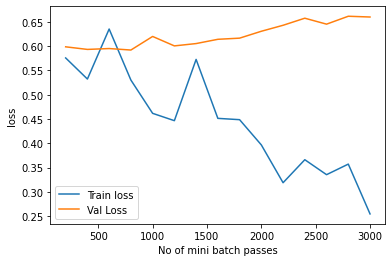

In [20]:
train_validate(30,1e-4,100,1)

Epoch: 2/30... Step: 200... Loss: 0.766395... Val Loss: 0.747357
Epoch: 4/30... Step: 400... Loss: 0.628450... Val Loss: 0.689536
Epoch: 6/30... Step: 600... Loss: 0.666671... Val Loss: 0.637955
Epoch: 8/30... Step: 800... Loss: 0.539176... Val Loss: 0.605850
Epoch: 10/30... Step: 1000... Loss: 0.515474... Val Loss: 0.607119
Epoch: 12/30... Step: 1200... Loss: 0.513623... Val Loss: 0.604685
Epoch: 14/30... Step: 1400... Loss: 0.627524... Val Loss: 0.604414
Epoch: 16/30... Step: 1600... Loss: 0.609393... Val Loss: 0.603509
Epoch: 18/30... Step: 1800... Loss: 0.567272... Val Loss: 0.601637
Epoch: 20/30... Step: 2000... Loss: 0.551852... Val Loss: 0.600381
Epoch: 21/30... Step: 2200... Loss: 0.470458... Val Loss: 0.600060
Epoch: 23/30... Step: 2400... Loss: 0.634687... Val Loss: 0.602515
Epoch: 25/30... Step: 2600... Loss: 0.554670... Val Loss: 0.598130
Epoch: 27/30... Step: 2800... Loss: 0.576327... Val Loss: 0.600625
Epoch: 29/30... Step: 3000... Loss: 0.501408... Val Loss: 0.598772
The

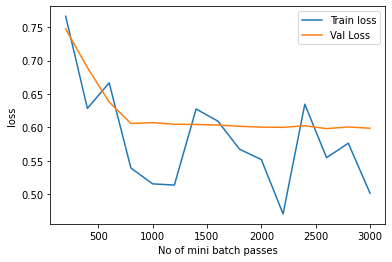

In [21]:
train_validate(30,1e-5,100,1)

Epoch: 2/30... Step: 200... Loss: 0.597252... Val Loss: 0.606287
Epoch: 4/30... Step: 400... Loss: 0.536727... Val Loss: 0.597267
Epoch: 6/30... Step: 600... Loss: 0.634742... Val Loss: 0.601369
Epoch: 8/30... Step: 800... Loss: 0.536007... Val Loss: 0.596346
Epoch: 10/30... Step: 1000... Loss: 0.501413... Val Loss: 0.598637
Epoch: 12/30... Step: 1200... Loss: 0.494493... Val Loss: 0.594653
Epoch: 14/30... Step: 1400... Loss: 0.621890... Val Loss: 0.592884
Epoch: 16/30... Step: 1600... Loss: 0.556722... Val Loss: 0.593087
Epoch: 18/30... Step: 1800... Loss: 0.512880... Val Loss: 0.592961
Epoch: 20/30... Step: 2000... Loss: 0.521364... Val Loss: 0.593443
Epoch: 21/30... Step: 2200... Loss: 0.447578... Val Loss: 0.601535
Epoch: 23/30... Step: 2400... Loss: 0.519061... Val Loss: 0.601177
Epoch: 25/30... Step: 2600... Loss: 0.533357... Val Loss: 0.599993
Epoch: 27/30... Step: 2800... Loss: 0.541260... Val Loss: 0.602043
Epoch: 29/30... Step: 3000... Loss: 0.430955... Val Loss: 0.608314
The

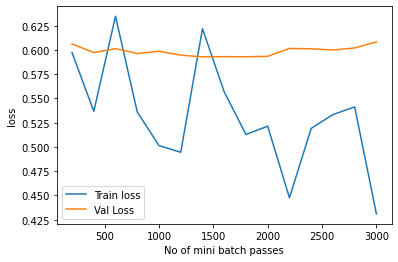

In [22]:
train_validate(30,4e-5,100,1)

Epoch: 2/30... Step: 200... Loss: 1.001508... Val Loss: 0.923290
Epoch: 4/30... Step: 400... Loss: 0.836348... Val Loss: 0.840140
Epoch: 6/30... Step: 600... Loss: 0.675542... Val Loss: 0.638860
Epoch: 8/30... Step: 800... Loss: 0.660215... Val Loss: 0.607813
Epoch: 10/30... Step: 1000... Loss: 0.562089... Val Loss: 0.609236
Epoch: 12/30... Step: 1200... Loss: 0.639467... Val Loss: 0.598813
Epoch: 14/30... Step: 1400... Loss: 0.623685... Val Loss: 0.602985
Epoch: 16/30... Step: 1600... Loss: 0.607469... Val Loss: 0.600149
Epoch: 18/30... Step: 1800... Loss: 0.576420... Val Loss: 0.598762
Epoch: 20/30... Step: 2000... Loss: 0.559175... Val Loss: 0.599498
Epoch: 21/30... Step: 2200... Loss: 0.539827... Val Loss: 0.596630
Epoch: 23/30... Step: 2400... Loss: 0.594304... Val Loss: 0.595568
Epoch: 25/30... Step: 2600... Loss: 0.557878... Val Loss: 0.595662
Epoch: 27/30... Step: 2800... Loss: 0.625033... Val Loss: 0.594271
Epoch: 29/30... Step: 3000... Loss: 0.580869... Val Loss: 0.596066
The

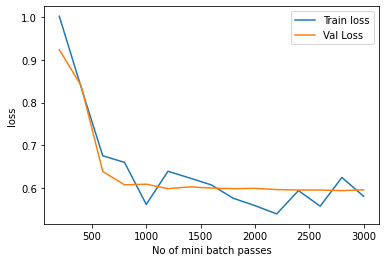

In [23]:
train_validate(30,1e-5,150,1)

Epoch: 4/60... Step: 400... Loss: 0.960719... Val Loss: 0.920333
Epoch: 8/60... Step: 800... Loss: 0.952494... Val Loss: 0.916436
Epoch: 12/60... Step: 1200... Loss: 0.907691... Val Loss: 0.910395
Epoch: 16/60... Step: 1600... Loss: 0.930974... Val Loss: 0.897145
Epoch: 20/60... Step: 2000... Loss: 0.849256... Val Loss: 0.881837
Epoch: 23/60... Step: 2400... Loss: 0.836394... Val Loss: 0.838230
Epoch: 27/60... Step: 2800... Loss: 0.682041... Val Loss: 0.754888
Epoch: 31/60... Step: 3200... Loss: 0.617096... Val Loss: 0.696001
Epoch: 35/60... Step: 3600... Loss: 0.696301... Val Loss: 0.655757
Epoch: 39/60... Step: 4000... Loss: 0.566630... Val Loss: 0.632410
Epoch: 42/60... Step: 4400... Loss: 0.601260... Val Loss: 0.619903
Epoch: 46/60... Step: 4800... Loss: 0.481403... Val Loss: 0.607814
Epoch: 50/60... Step: 5200... Loss: 0.578510... Val Loss: 0.602203
Epoch: 54/60... Step: 5600... Loss: 0.558014... Val Loss: 0.598048
Epoch: 58/60... Step: 6000... Loss: 0.588306... Val Loss: 0.599305

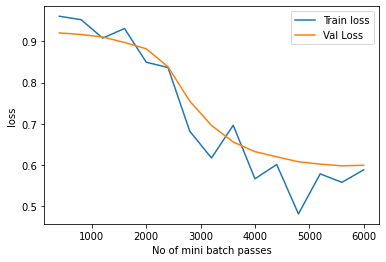

In [29]:
train_validate(60,1e-5,50,1,400)

Inferences from hyperparameter tuning:
1. For batch size of 64, having a learning rate of 1e-4 results in overfitting.
2. Learning rate of 1e-5 fixes this.
3. Reducing hidden dimension makes network start of with a higher val and train loss but it eventually plateus to around 0.59. 
4. in fact any model which is generalsing well gives us a best validation loss of 0.59.
5. Increasing number of layers of lstm just makes it reach a loss of 0.59 earlier and it platues after that.